<a href="https://colab.research.google.com/github/harshad317/CIPLA_hackerthon/blob/main/cipla_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install optuna
#!pip install catboost
#!pip install feature_engine
#!pip install category_encoders
#!pip install rfpimp
#!pip install interpret

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, PowerTransformer, QuantileTransformer, StandardScaler, RobustScaler, KBinsDiscretizer
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit, KFold, GridSearchCV, RepeatedKFold
from itertools import combinations
from tqdm.notebook import tqdm
from rfpimp import permutation_importances
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
import scipy.stats as stats
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
import optuna
from category_encoders import CatBoostEncoder, LeaveOneOutEncoder, BinaryEncoder, JamesSteinEncoder, WOEEncoder, TargetEncoder
from scipy.stats import chi2_contingency
from feature_engine.encoding import PRatioEncoder, MeanEncoder
from sklearn.decomposition import NMF
from rfpimp import permutation_importances
from feature_engine.outliers import Winsorizer
from scipy.stats import spearmanr

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train.shape,train.isnull().mean()*100

((30000, 24),
 Customer ID                     0.000000
 Name                            0.000000
 Gender                          0.176667
 Age                             0.000000
 Income (USD)                   15.253333
 Income Stability                5.610000
 Profession                      0.000000
 Type of Employment             24.233333
 Location                        0.000000
 Loan Amount Request (USD)       0.000000
 Current Loan Expenses (USD)     0.573333
 Expense Type 1                  0.000000
 Expense Type 2                  0.000000
 Dependents                      8.310000
 Credit Score                    5.676667
 No. of Defaults                 0.000000
 Has Active Credit Card          5.220000
 Property ID                     0.000000
 Property Age                   16.166667
 Property Type                   0.000000
 Property Location               1.186667
 Co-Applicant                    0.000000
 Property Price                  0.000000
 Loan Sanction Amoun

#### Removing the rows which doesn't provide any predicting power

In [ ]:
train.dropna(axis=0, subset=['Loan Sanction Amount (USD)'], inplace=True, how='any')

In [ ]:
train.head()

,Customer ID,Name,Gender,Age,Income (USD),Income Stability,Profession,Type of Employment,Location,Loan Amount Request (USD),Current Loan Expenses (USD),Expense Type 1,Expense Type 2,Dependents,Credit Score,No. of Defaults,Has Active Credit Card,Property ID,Property Age,Property Type,Property Location,Co-Applicant,Property Price,Loan Sanction Amount (USD)
0,C-36995,Frederica Shealy,F,56,1933.05,Low,Working,Sales staff,Semi-Urban,72809.58,241.08,N,N,3.0,809.44,0,NaN,746,1933.05,4,Rural,1,119933.46,54607.18
1,C-33999,America Calderone,M,32,4952.91,Low,Working,NaN,Semi-Urban,46837.47,495.81,N,Y,1.0,780.40,0,Unpossessed,608,4952.91,2,Rural,1,54791.00,37469.98
2,C-3770,Rosetta Verne,F,65,988.19,High,Pensioner,NaN,Semi-Urban,45593.04,171.95,N,Y,1.0,833.15,0,Unpossessed,546,988.19,2,Urban,0,72440.58,36474.43
3,C-26480,Zoe Chitty,F,65,NaN,High,Pensioner,NaN,Rural,80057.92,298.54,N,Y,2.0,832.70,1,Unpossessed,890,NaN,2,Semi-Urban,1,121441.51,56040.54
4,C-23459,Afton Venema,F,31,2614.77,Low,Working,High skill tech staff,Semi-Urban,113858.89,491.41,N,Y,NaN,745.55,1,Active,715,2614.77,4,Semi-Urban,1,208567.91,74008.28


#### Income and Property Age columns shares same values which is unusual.

In [ ]:
train.nunique()

Customer ID                    29660
Name                           29660
Gender                             2
Age                               48
Income (USD)                   24187
Income Stability                   2
Profession                         8
Type of Employment                18
Location                           3
Loan Amount Request (USD)      29642
Current Loan Expenses (USD)    23816
Expense Type 1                     2
Expense Type 2                     2
Dependents                        10
Credit Score                   17477
No. of Defaults                    2
Has Active Credit Card             3
Property ID                      999
Property Age                   23944
Property Type                      4
Property Location                  3
Co-Applicant                       3
Property Price                 29303
Loan Sanction Amount (USD)     21450
dtype: int64

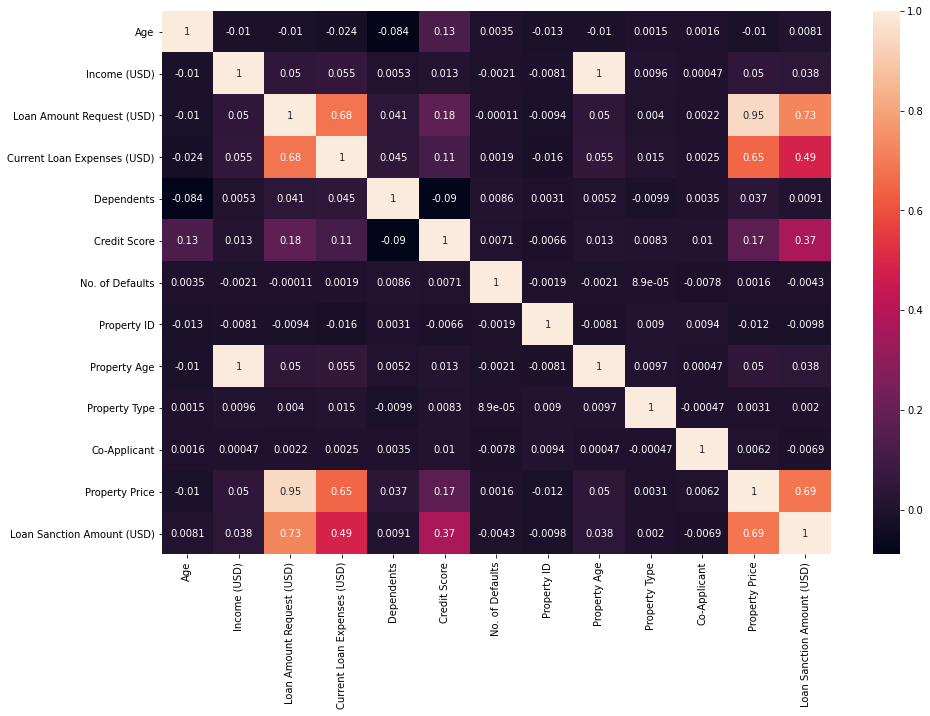

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(train.corr(), annot= True)

#### Property price and Loan Amount Requested are highly corelated. It means the loan given to the customer is highly based on his/her property evaluation and not on his/her income.

In [ ]:
train.describe()

,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property ID,Property Age,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD)
count,29660.000000,2.516700e+04,29660.000000,29493.000000,27214.000000,27990.000000,29660.000000,29660.000000,2.490000e+04,29660.000000,29660.000000,2.966000e+04,29660.000000
mean,40.099225,2.630991e+03,88792.057274,400.893752,2.253399,739.853475,0.194066,501.881827,2.631317e+03,2.460013,-4.707788,1.317335e+05,47649.342208
std,16.050024,1.131902e+04,59480.995253,242.265401,0.951987,72.152128,0.395487,288.160738,1.137831e+04,1.118695,74.369350,9.342129e+04,48221.146686
min,18.000000,3.777000e+02,6048.240000,-999.000000,1.000000,580.000000,0.000000,1.000000,3.777000e+02,1.000000,-999.000000,-9.990000e+02,-999.000000
25%,25.000000,1.650250e+03,41200.112500,247.780000,2.000000,681.732500,0.000000,251.000000,1.649810e+03,1.000000,1.000000,6.065874e+04,0.000000
50%,40.000000,2.223300e+03,75114.085000,375.090000,2.000000,739.815000,0.000000,504.000000,2.223965e+03,2.000000,1.000000,1.099936e+05,35209.395000
75%,55.000000,3.090330e+03,119890.857500,521.050000,3.000000,799.040000,0.000000,751.000000,3.090833e+03,3.000000,1.000000,1.788019e+05,74261.250000
max,65.000000,1.777460e+06,621497.820000,3840.880000,14.000000,896.260000,1.000000,999.000000,1.777460e+06,4.000000,1.000000,1.077967e+06,481907.320000


In [ ]:
test['Co-Applicant'] = test['Co-Applicant'].astype(str).replace('?', -999)
test['Property Price'] = test['Property Price'].astype(str).replace('?', np.nan)

In [ ]:
test['Co-Applicant']= test['Co-Applicant'].astype(float)
test['Property Price'] = test['Property Price'].astype(float)

In [ ]:
df = pd.concat([train, test], axis= 0, sort=False)

In [ ]:
df.Gender.fillna(value='F', inplace= True, axis= 0)

In [ ]:
df['Age_bins']= pd.cut(x=df['Age'], bins= 10, labels=False)

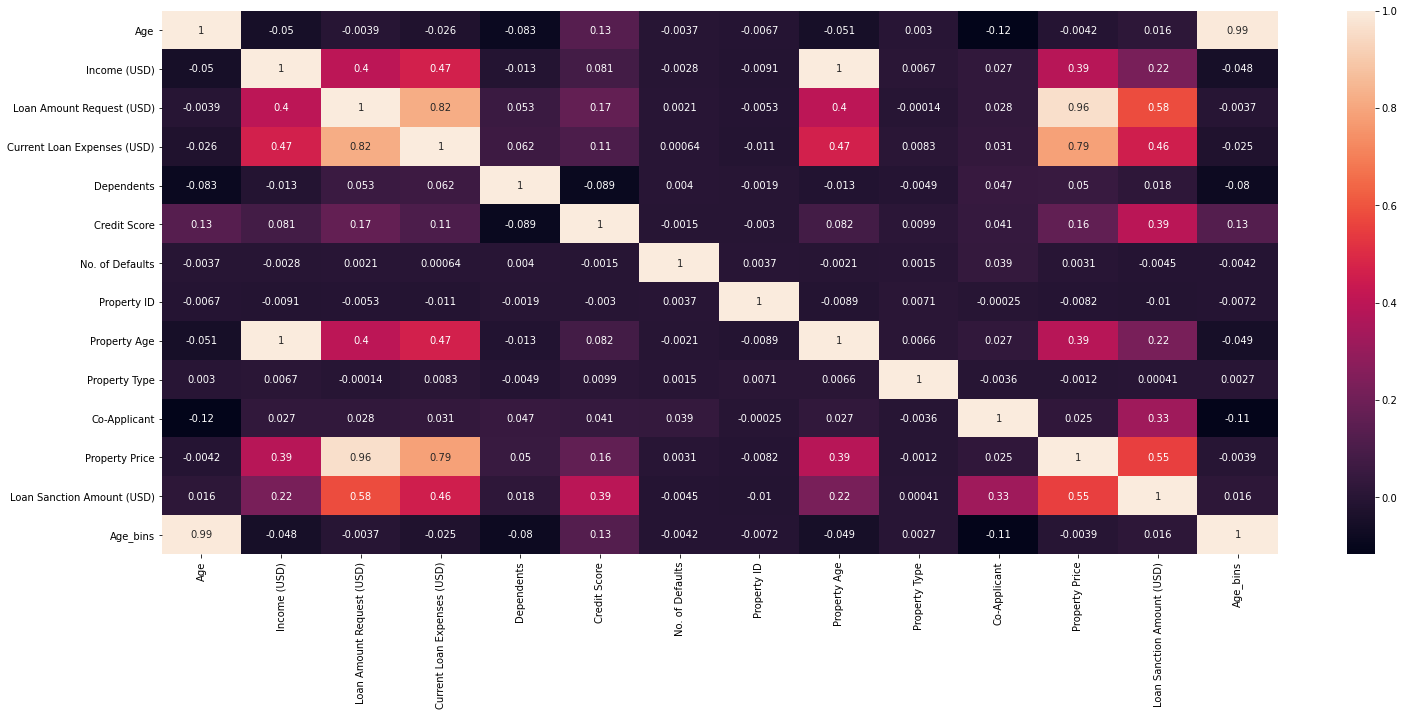

In [ ]:
plt.figure(figsize=(25,10))
sns.heatmap(df.corr('spearman'), annot= True)

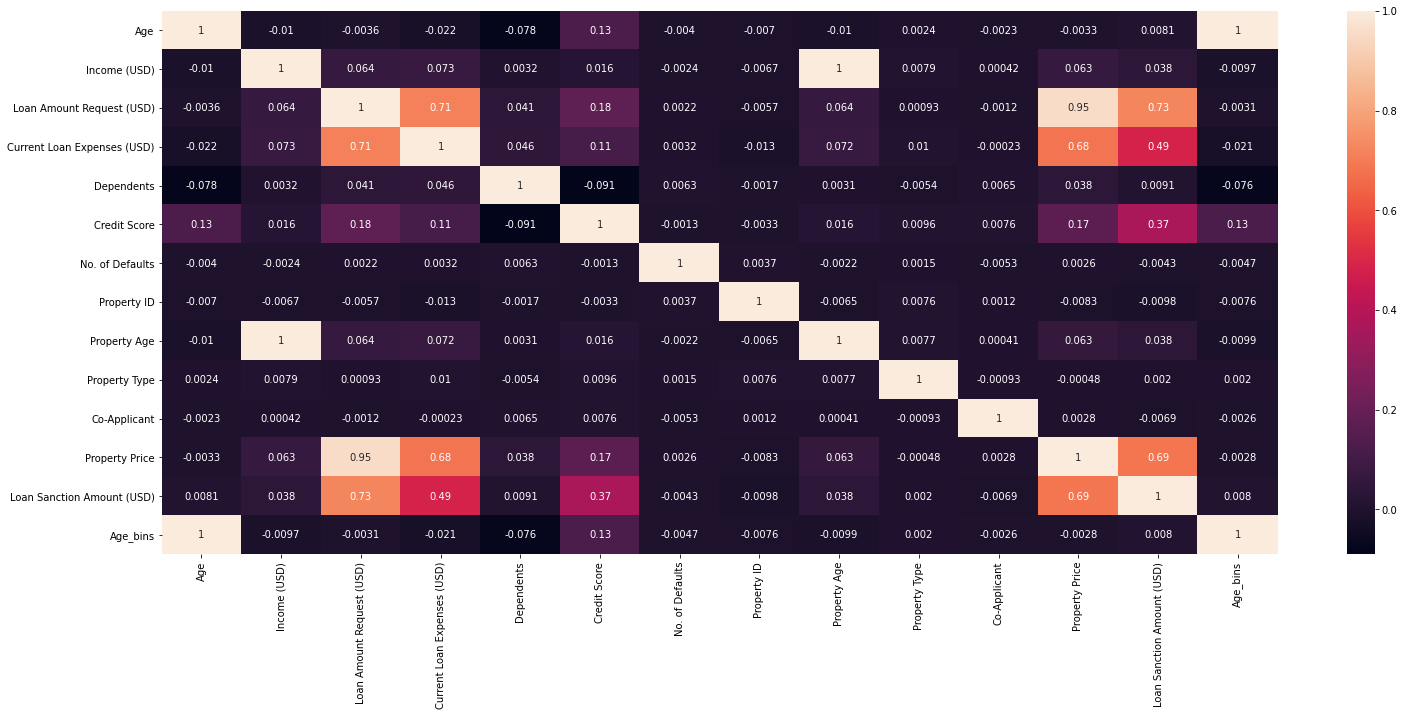

In [ ]:
plt.figure(figsize=(25,10))
sns.heatmap(df.corr('pearson'), annot= True)

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
imputer = IterativeImputer(
    estimator=XGBRegressor(), # the estimator to predict the NA
    initial_strategy='median', # how will NA be imputed in step 1
    max_iter=100, # number of cycles
    imputation_order='ascending', # the order in which to impute the variables
    n_nearest_features=3, # whether to limit the number of predictors
    skip_complete=True, # whether to ignore variables without NA
    random_state=0,
)

In [ ]:
asd = df['Income (USD)'].values.reshape(-1,1)

In [ ]:
imputer.fit(asd)

IterativeImputer(add_indicator=False,
                 estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                        colsample_bylevel=1, colsample_bynode=1,
                                        colsample_bytree=1, gamma=0,
                                        importance_type='gain',
                                        learning_rate=0.1, max_delta_step=0,
                                        max_depth=3, min_child_weight=1,
                                        missing=None, n_estimators=100,
                                        n_jobs=1, nthread=None,
                                        objective='reg:linear', random_state=0,
                                        reg_alpha=0, reg_lambda=1,
                                        scale_pos_weight=1, seed=None,
                                        silent=None, subsample=1, verbosity=1),
                 imputation_order='ascending', initial_strategy='median',
                

In [ ]:
df['Income (USD)'] = imputer.transform(asd)

In [ ]:
df['Income (USD)'] = np.round(df['Income (USD)'], decimals=2)

In [ ]:
df['Type of Employment'].fillna(value= 'Unknown_employment', inplace= True, axis= 0)

In [ ]:
df['Income Stability'].fillna(value= 'Unknown_stability', inplace= True, axis= 0)

In [ ]:
asd = df['Current Loan Expenses (USD)'].values.reshape(-1,1)

In [ ]:
imputer.fit(asd)
df['Current Loan Expenses (USD)'] = imputer.transform(asd)

In [ ]:

asd = df.Dependents.values.reshape(-1,1)

In [ ]:
imputer.fit(asd)
df['Dependents'] = imputer.transform(asd)

In [ ]:
df['Dependents'] = np.round(df['Dependents'], decimals=0)

In [ ]:
asd = df['Credit Score'].values.reshape(-1,1)

In [ ]:
imputer.fit(asd)
df['Credit Score'] = imputer.transform(asd)

In [ ]:
df['Has Active Credit Card'].fillna(value= 'Unknown_credit_card', inplace= True, axis= 0)

In [ ]:
asd = df['Property Age'].values.reshape(-1,1)

In [ ]:
imputer.fit(asd)
df['Property Age'] = imputer.transform(asd)

In [ ]:
df['Property Age'] = np.round(df['Property Age'], decimals=2)

In [ ]:
df['Property Location'].fillna(value= 'Unknown_property_location', inplace= True, axis= 0)

In [ ]:
asd = df['Property Price'].values.reshape(-1,1)

In [ ]:
imputer.fit(asd)
df['Property Price'] = imputer.transform(asd)

In [ ]:
df['Property ID'] = df['Property ID'].astype(str)

In [ ]:
df['Property_age']= df.groupby(['Property ID'])['Property Age'].transform('mean')
df['Property_price']= df.groupby(['Property ID'])['Property Price'].transform('mean')
df['Property_location'] = df.groupby(['Property Location'])['Property ID'].transform('count')
df['People on same property']= df.groupby(['Property ID'])['Customer ID'].transform('count')
df['Property_co_app'] = df.groupby(['Property ID'])['Co-Applicant'].transform('count')

In [ ]:
df['Current Loan Expenses (USD) Yearly'] = df['Current Loan Expenses (USD)'] * 12

In [ ]:
df['loan_yearly'] = df['Loan Amount Request (USD)']/df['Current Loan Expenses (USD) Yearly']

In [ ]:
df['co_app_by_loan_asked_mean']= df.groupby(['Co-Applicant'])['Loan Amount Request (USD)'].transform('mean')
df['co_app_by_loan_asked_median']= df.groupby(['Co-Applicant'])['Loan Amount Request (USD)'].transform('median')

In [ ]:
df['prop_id_by_loan_asked_mean']= df.groupby(['Property ID'])['Loan Amount Request (USD)'].transform('mean')
df['prop_id_by_loan_asked_median']= df.groupby(['Property ID'])['Loan Amount Request (USD)'].transform('median')

In [ ]:
df['Property ID'] = df['Property ID'].astype(float)

In [ ]:
df['emp_id_mean']= df.groupby(['Type of Employment'])['Property ID'].transform('mean')
df['emp_id_median']= df.groupby(['Type of Employment'])['Property ID'].transform('median')

df['cred_id_mean']= df.groupby(['Has Active Credit Card'])['Property ID'].transform('mean')
df['cred_id_median']= df.groupby(['Has Active Credit Card'])['Property ID'].transform('median')

In [ ]:
df['cred_by_defaults']= df['Has Active Credit Card'].astype(str) + '_' + df['No. of Defaults'].astype(str)

In [ ]:
df['asked_by_location_mean']= df.groupby(['Property Location'])['Loan Amount Request (USD)'].transform('mean')
df['asked_by_location_median']= df.groupby(['Property Location'])['Loan Amount Request (USD)'].transform('median')

In [ ]:
df['emp_location'] = df['Type of Employment'].astype(str) + '_' + df['Location'].astype(str)
df['emp_prop_location'] = df['Type of Employment'].astype(str) + '_' + df['Property Location'].astype(str)
df['loc_type']= df['Property Location'].astype(str) + '_' + df['Property Type'].astype(str)
df['prof_by_employment']= df['Profession'].astype(str) + '_' + df['Type of Employment'].astype(str)

In [ ]:
df['emp_gender']= df['Type of Employment'].astype(str) + '_' + df['Gender'].astype(str)
df['emp_profession']= df['Type of Employment'].astype(str) + '_' + df['Profession'].astype(str)
df['emp_loc']= df['Type of Employment'].astype(str) + '_' + df['Location'].astype(str)

In [ ]:
df['Gender_loan_asked_mean']= df.groupby(['Gender'])['Loan Amount Request (USD)'].transform('mean')
df['Gender_loan_asked_median']= df.groupby(['Gender'])['Loan Amount Request (USD)'].transform('median')

In [ ]:
df['ID_by_price_mean']= df.groupby(['Property ID'])['Property Price'].transform('mean')
df['ID_by_price_median']= df.groupby(['Property ID'])['Property Price'].transform('median')

In [ ]:
df['income_stab_by_loan_asked_mean']= df.groupby(['Income Stability'])['Loan Amount Request (USD)'].transform('mean')
df['income_stab_by_loan_asked_median']= df.groupby(['Income Stability'])['Loan Amount Request (USD)'].transform('median')

In [ ]:
gend = pd.get_dummies(df.Gender, drop_first=True)
df = df.drop('Gender', axis= 1)
df = pd.concat([df, gend], axis= 1)

In [ ]:
stab = pd.get_dummies(df['Income Stability'], drop_first=True, prefix = 'stab_')
df = df.drop('Income Stability', axis= 1)
df = pd.concat([df, stab], axis= 1)

In [ ]:
df['Max_amount_allowed'] = (df['Loan Amount Request (USD)'] *80)/100

In [ ]:
df['Margin']= df['Loan Amount Request (USD)'] - df.Max_amount_allowed

In [ ]:
df['loan_for_4_years'] = df['Loan Amount Request (USD)']/48
df['loan_for_5_years'] = df['Loan Amount Request (USD)']/60
df['loan_for_6_years']= df['Loan Amount Request (USD)']/72

In [ ]:
train = df.iloc[:29660]
test = df.iloc[29660:]

In [ ]:
[var for var in train.columns if train[var].dtypes == 'O']

['Customer ID',
 'Name',
 'Profession',
 'Type of Employment',
 'Location',
 'Expense Type 1',
 'Expense Type 2',
 'Has Active Credit Card',
 'Property Location',
 'cred_by_defaults',
 'emp_location',
 'emp_prop_location',
 'loc_type',
 'prof_by_employment',
 'emp_gender',
 'emp_profession',
 'emp_loc']

In [ ]:
cat_cols = ['Customer ID',
 'Name',
 'Gender',
 'Income Stability',
 'Profession',
 'Type of Employment',
 'Location',
 'Expense Type 1',
 'Expense Type 2',
 'Has Active Credit Card',
 'Property ID',
 'Property Location']

In [ ]:
[var for var in train.columns if train[var].dtypes != 'O']

['Age',
 'Income (USD)',
 'Loan Amount Request (USD)',
 'Current Loan Expenses (USD)',
 'Dependents',
 'Credit Score',
 'No. of Defaults',
 'Property ID',
 'Property Age',
 'Property Type',
 'Co-Applicant',
 'Property Price',
 'Loan Sanction Amount (USD)',
 'Age_bins',
 'Property_age',
 'Property_price',
 'Property_location',
 'People on same property',
 'Property_co_app',
 'Current Loan Expenses (USD) Yearly',
 'loan_yearly',
 'co_app_by_loan_asked_mean',
 'co_app_by_loan_asked_median',
 'prop_id_by_loan_asked_mean',
 'prop_id_by_loan_asked_median',
 'emp_id_mean',
 'emp_id_median',
 'cred_id_mean',
 'cred_id_median',
 'asked_by_location_mean',
 'asked_by_location_median',
 'Gender_loan_asked_mean',
 'Gender_loan_asked_median',
 'ID_by_price_mean',
 'ID_by_price_median',
 'income_stab_by_loan_asked_mean',
 'income_stab_by_loan_asked_median',
 'M',
 'stab__Low',
 'stab__Unknown_stability',
 'Max_amount_allowed',
 'Margin',
 'loan_for_4_years',
 'loan_for_5_years',
 'loan_for_6_years']

In [ ]:
from category_encoders import BinaryEncoder, JamesSteinEncoder

be = JamesSteinEncoder(sigma=0.1)
train[cat_cols] = be.fit_transform(train[cat_cols], train['Loan Sanction Amount (USD)'])
test[cat_cols] = be.transform(test[cat_cols])

In [ ]:
cont_cols =  ['Age',
 'Income (USD)',
 'Loan Amount Request (USD)',
 'Current Loan Expenses (USD)',
 'Dependents',
 'Credit Score',
 'No. of Defaults',
 'Property ID',
 'Property Age',
 'Property Type',
 'Co-Applicant',
 'Property Price',
 'Age_bins',
 'Property_age',
 'Property_price',
 'Property_location',
 'People on same property',
 'Property_co_app',
 'Current Loan Expenses (USD) Yearly',
 'co_app_by_loan_asked_mean',
 'co_app_by_loan_asked_median',
 'prop_id_by_loan_asked_mean',
 'prop_id_by_loan_asked_median',
 'emp_id_mean',
 'emp_id_median',
 'cred_id_mean',
 'cred_id_median',
 'asked_by_location_mean',
 'asked_by_location_median',
 'Gender_loan_asked_mean',
 'Gender_loan_asked_median',
 'ID_by_price_mean',
 'ID_by_price_median',
 'income_stab_by_loan_asked_mean',
 'income_stab_by_loan_asked_median',
 'M',
 'stab__Low',
 'stab__Unknown_stability',
 'Max_amount_allowed',
 'Margin',
 'loan_for_4_years',
 'loan_for_5_years',
 'loan_for_6_years']

In [ ]:
X_train = train[cont_cols + cat_cols]
y_train = train['Loan Sanction Amount (USD)']
X_test = test[cont_cols + cat_cols]

In [ ]:
lgbm_params= {'reg_lambda': 5.510814527328319,
 'reg_alpha': 0.0341284438139411,
 'colsample_bytree': 0.7,
 'subsample': 0.7,
 'learning_rate': 0.06402494793370021,
 'max_depth': 46,
 'min_child_weight': 6}

In [ ]:
n_folds = 10
subbed = []
kf = KFold(n_splits=n_folds, shuffle=True, random_state=10)


for fold, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
    print('=============== Fold No:',fold+1,'===============')
    X_tr, X_tst = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_tr, y_tst = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    model = LGBMRegressor(**lgbm_params, verbose=0, n_estimators=10000, objective = 'regression')
    model.fit(X_tr, y_tr,eval_set=[(X_tst, y_tst)], early_stopping_rounds=30,verbose=100)
    print(r2_score(y_tst, model.predict(X_tst)))
    subbed.append(r2_score(y_tst, model.predict(X_tst)))
    pred = model.predict(X_test)
print(np.mean(subbed))

=============== Fold No: 1 ===============
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's l2: 4.76368e+08
Early stopping, best iteration is:
[127]	valid_0's l2: 4.74278e+08
0.7996333761431964
=============== Fold No: 2 ===============
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's l2: 5.51154e+08
Early stopping, best iteration is:
[99]	valid_0's l2: 5.50893e+08
0.7632174807285295
=============== Fold No: 3 ===============
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's l2: 5.19608e+08
Early stopping, best iteration is:
[128]	valid_0's l2: 5.18353e+08
0.777591377477405
=============== Fold No: 4 ===============
Training until validation scores don't improve for 30 rounds.
[100]	valid_0's l2: 5.02623e+08
Early stopping, best iteration is:
[109]	valid_0's l2: 5.02422e+08
0.7746996593931981
=============== Fold No: 5 ===============
Training until validation scores don't improve for 30 rounds.
[100]

In [ ]:
sub = pd.DataFrame()
sub['Customer ID'] = test['Customer ID']
sub['Loan Sanction Amount (USD)'] = pred
sub.to_csv('lgbm.csv', index= False)

In [ ]:
# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df):
    plt.figure(figsize=(15,10))
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue')

In [ ]:
def r2(rf, X_train, y_train):
    return r2_score(y_train, model.predict(X_train))

perm_imp_rfpimp = permutation_importances(model, X_train, y_train, r2)
perm_imp_rfpimp.reset_index(drop = False, inplace = True)

In [ ]:
var_imp_plot(perm_imp_rfpimp)

#### Tuning

In [ ]:
X = train[cont_cols + cat_cols]
y = train['Loan Sanction Amount (USD)']

In [ ]:
def objective(trial,data=X,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.15,random_state=42)
    
    # To select which parameters to optimize, please look at the XGBoost documentation:
    # https://xgboost.readthedocs.io/en/latest/parameter.html
    param = {
        #'objective': 'regression',
        #'tree_method':'gpu_hist',  # Use GPU acceleration
        'reg_lambda': trial.suggest_loguniform(
            'reg_lambda', 1e-3, 10.0
        ),
        'reg_alpha': trial.suggest_loguniform(
            'reg_alpha', 1e-3, 10.0
        ),
        'colsample_bytree': trial.suggest_categorical(
            'colsample_bytree', [0.5,0.6,0.7,0.8,0.9,1.0]
        ),
        'subsample': trial.suggest_categorical(
            'subsample', [0.5,0.6,0.7,0.8,0.9,1.0]
        ),
        'learning_rate': trial.suggest_loguniform(
            'learning_rate', 1e-5, 1e-1
        ),
        'max_depth': trial.suggest_int(
            'max_depth', 2,50
        ),
        'random_state': 2021,
        'min_child_weight': trial.suggest_int(
            'min_child_weight', 1, 300
        ),
    }
    n_folds = 10
    subbed = []
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=10)


    for fold, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
        #print('=============== Fold No:',fold+1,'===============')
        X_tr, X_tst = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_tr, y_tst = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
        model = LGBMRegressor(**param, verbose=0,objective = 'regression')
        model.fit(X_tr, y_tr,eval_set=[(X_tst, y_tst)], early_stopping_rounds=30,verbose=100)
        #print(r2_score(y_tst, model.predict(X_tst)))
        subbed.append(r2_score(y_tst, model.predict(X_tst)))
        pred = model.predict(X_test)
    return (np.mean(subbed))

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [ ]:
study.best_params

{'reg_lambda': 0.7182490692470639,
 'reg_alpha': 0.0015120582342600247,
 'colsample_bytree': 0.5,
 'subsample': 0.7,
 'learning_rate': 0.07839201893959348,
 'max_depth': 6,
 'min_child_weight': 21}